In [9]:
from IPython import get_ipython
import datetime
import pandas as pd
import numpy as np
import plotly.express as px
from sodapy import Socrata
import geopandas as gpd
import geopy
dir(geopy)
from geopy.geocoders import Photon
dir(Photon)
from geopy.geocoders import Nominatim
import time
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from geopy import distance
import osmnx as ox
import contextily as ctx
import sys
import json
import folium
dir(folium)

['Choropleth',
 'Circle',
 'CircleMarker',
 'ClickForMarker',
 'ColorLine',
 'ColorMap',
 'CssLink',
 'CustomIcon',
 'Div',
 'DivIcon',
 'Element',
 'FeatureGroup',
 'Figure',
 'FitBounds',
 'GeoJson',
 'GeoJsonPopup',
 'GeoJsonTooltip',
 'Html',
 'IFrame',
 'Icon',
 'JavascriptLink',
 'LatLngPopup',
 'LayerControl',
 'LinearColormap',
 'Link',
 'MacroElement',
 'Map',
 'Marker',
 'PolyLine',
 'Polygon',
 'Popup',
 'Rectangle',
 'RegularPolygonMarker',
 'StepColormap',
 'TileLayer',
 'Tooltip',
 'TopoJson',
 'Vega',
 'VegaLite',
 'WmsTileLayer',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_version',
 'branca',
 'features',
 'folium',
 'map',
 'raster_layers',
 'sys',
 'utilities',
 'vector_layers']

In [11]:
# connect to the data portal
client = Socrata("data.lacity.org", None)

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("tkh9-tssh", limit=2000)

# Convert to pandas DataFrame
df = pd.DataFrame.from_records(results)

# print it with .sample, which gives you random rows
df.sample(2)



zip_code         city business_name            location_description  \
1819  93551-4861     PALMDALE    IVES LEMOS         40039 DENHAM 93551-4861   
795   90034-2772  LOS ANGELES       MIKE YI  3344 CASTLE HEIGHTS 90034-2772   

                       street_address        location_end_date  \
1819               40039 DENHAM DRIVE  2008-02-20T00:00:00.000   
795   3344 CASTLE HEIGHTS AVENUE #401  2008-01-31T00:00:00.000   

          location_start_date   location_account council_district  \
1819  1999-06-03T00:00:00.000  0000963135-0001-0                0   
795   2000-01-01T00:00:00.000  0002029385-0001-2               10   

     mailing_city  ... location :@computed_region_qz3q_ghft  \
1819          NaN  ...      NaN                         NaN   
795           NaN  ...      NaN                         NaN   

     :@computed_region_k96s_3jcv :@computed_region_kqwf_mjcx  \
1819                         NaN                         NaN   
795                          NaN                         NaN   

     :@computed_region_2dna_qi2s naics primary_naics_description  \
1819                         NaN   NaN                       NaN   
795                          NaN   NaN                       NaN   

     :@computed_region_tatf_ua23 :@computed_region_ur2y_g4cx       dba_name  
1819                         NaN                         NaN  LEMOS SEAFOOD  
795                          NaN                         NaN            NaN  

[2 rows x 22 columns]

In [12]:
# add a "where" statement
results = client.get("tkh9-tssh", 
                     limit = 10000, # putting an arbitrary high number (otherwise defaults to 1000)
                     where = "location_end_date between '2020-03-19T00:00:00.000' and '2021-03-19T00:00:00' AND city = 'LOS ANGELES'"
                    )

In [13]:
# Convert to pandas DataFrame
df = pd.DataFrame.from_records(results)

In [14]:
df.shape


(3328, 16)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3328 entries, 0 to 3327
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   zip_code                   3328 non-null   object
 1   city                       3328 non-null   object
 2   business_name              3328 non-null   object
 3   location_description       3328 non-null   object
 4   street_address             3328 non-null   object
 5   location_end_date          3328 non-null   object
 6   location_start_date        3328 non-null   object
 7   location_account           3328 non-null   object
 8   council_district           3328 non-null   object
 9   location                   468 non-null    object
 10  naics                      438 non-null    object
 11  primary_naics_description  438 non-null    object
 12  mailing_city               293 non-null    object
 13  mailing_zip_code           292 non-null    object
 14  mailing_

In [16]:
df.head()

zip_code         city            business_name  \
0  90011-2334  LOS ANGELES           DILCIA L ELIAS   
1  90015-2510  LOS ANGELES  GUILLERMO ESTRADA PRADO   
2  90032-1806  LOS ANGELES     RICHARD J ANDRADE SR   
3  90006-5409  LOS ANGELES      PACKWOOD TRAILS INC   
4  90015-2508  LOS ANGELES             YAFA BARLAVI   

         location_description                 street_address  \
0    307 JEFFERSON 90011-2334           307 E JEFFERSON BLVD   
1         326 PICO 90015-2510                326 E PICO BLVD   
2   4348 ROSE HILL 90032-1806         4348 W ROSE HILL DRIVE   
3  1408 BURLINGTON 90006-5409  1408  1/2 S BURLINGTON AVENUE   
4         214 PICO 90015-2508                214 E PICO BLVD   

         location_end_date      location_start_date   location_account  \
0  2020-03-19T00:00:00.000  2019-12-17T00:00:00.000  0003167836-0001-1   
1  2020-03-19T00:00:00.000  2019-06-20T00:00:00.000  0003133275-0001-3   
2  2020-03-19T00:00:00.000  2000-01-01T00:00:00.000  0000804023-0001-2   
3  2020-03-19T00:00:00.000  2019-03-19T00:00:00.000  0003114366-0002-5   
4  2020-03-19T00:00:00.000  2013-08-01T00:00:00.000  0002693025-0001-0   

  council_district location naics primary_naics_description mailing_city  \
0                9      NaN   NaN                       NaN          NaN   
1               14      NaN   NaN                       NaN          NaN   
2               14      NaN   NaN                       NaN          NaN   
3                1      NaN   NaN                       NaN          NaN   
4               14      NaN   NaN                       NaN          NaN   

  mailing_zip_code mailing_address dba_name  
0              NaN             NaN      NaN  
1              NaN             NaN      NaN  
2              NaN             NaN      NaN  
3              NaN             NaN      NaN  
4              NaN             NaN      NaN

In [17]:
#gets rid of floor, apartment, suite, # in address Nominatim and other geocoders won't read it, still has errors, need to join neighborhoods to actual cities
pat = r'^(?P<number>\d+)?(?P<street>.+(?=\bAPT|\bFLOOR|\bBUILDING|\bSUITE|\bUNIT)|.+(?=#)|.+)(?P<apt_unit>(?:\bAPT|\bFLOOR|\bSUITE|\bUNIT|#).+)?'

#adds three columns after running extract
df[['number','street','apt_unit']]=df.street_address.str.extract(pat, expand=True)
df

zip_code         city              business_name  \
0     90011-2334  LOS ANGELES             DILCIA L ELIAS   
1     90015-2510  LOS ANGELES    GUILLERMO ESTRADA PRADO   
2     90032-1806  LOS ANGELES       RICHARD J ANDRADE SR   
3     90006-5409  LOS ANGELES        PACKWOOD TRAILS INC   
4     90015-2508  LOS ANGELES               YAFA BARLAVI   
...          ...          ...                        ...   
3323  90005-1661  LOS ANGELES      MARGARITA LOYOLA RUIZ   
3324  90024-3009  LOS ANGELES               PODSHARE INC   
3325  90044-3421  LOS ANGELES          OGDILIA E SANDERS   
3326  90062-1734  LOS ANGELES  JOSE ANTONIO TOLEDO TAPIA   
3327  90036-4139  LOS ANGELES                 PETRA NELL   

            location_description                    street_address  \
0       307 JEFFERSON 90011-2334              307 E JEFFERSON BLVD   
1            326 PICO 90015-2510                   326 E PICO BLVD   
2      4348 ROSE HILL 90032-1806            4348 W ROSE HILL DRIVE   
3     1408 BURLINGTON 90006-5409     1408  1/2 S BURLINGTON AVENUE   
4            214 PICO 90015-2508                   214 E PICO BLVD   
...                          ...                               ...   
3323      757 BERENDO 90005-1661         757 S BERENDO STREET #508   
3324      900 HILGARD 90024-3009                900 HILGARD AVENUE   
3325     8321 VERMONT 90044-3421             8321 S VERMONT AVENUE   
3326     4182 HARVARD 90062-1734               4182 S HARVARD BLVD   
3327   654 CLOVERDALE 90036-4139  654 S CLOVERDALE AVENUE APT #201   

            location_end_date      location_start_date   location_account  \
0     2020-03-19T00:00:00.000  2019-12-17T00:00:00.000  0003167836-0001-1   
1     2020-03-19T00:00:00.000  2019-06-20T00:00:00.000  0003133275-0001-3   
2     2020-03-19T00:00:00.000  2000-01-01T00:00:00.000  0000804023-0001-2   
3     2020-03-19T00:00:00.000  2019-03-19T00:00:00.000  0003114366-0002-5   
4     2020-03-19T00:00:00.000  2013-08-01T00:00:00.000  0002693025-0001-0   
...                       ...                      ...                ...   
3323  2021-03-15T00:00:00.000  2011-07-26T00:00:00.000  0002571329-0001-0   
3324  2021-03-15T00:00:00.000  2020-01-17T00:00:00.000  0002883390-0003-8   
3325  2021-03-15T00:00:00.000  2004-04-28T00:00:00.000  0000278978-0001-8   
3326  2021-03-15T00:00:00.000  2018-09-18T00:00:00.000  0003076217-0001-2   
3327  2021-03-15T00:00:00.000  2000-01-01T00:00:00.000  0002041778-0001-0   

     council_district                                           location  \
0                   9                                                NaN   
1                  14                                                NaN   
2                  14                                                NaN   
3                   1                                                NaN   
4                  14                                                NaN   
...               ...                                                ...   
3323               10  {'latitude': '34.0586', 'human_address': '{"ad...   
3324                5                                                NaN   
3325                8                                                NaN   
3326                8  {'latitude': '34.0074', 'human_address': '{"ad...   
3327                4                                                NaN   

       naics            primary_naics_description mailing_city  \
0        NaN                                  NaN          NaN   
1        NaN                                  NaN          NaN   
2        NaN                                  NaN          NaN   
3        NaN                                  NaN          NaN   
4        NaN                                  NaN          NaN   
...      ...                                  ...          ...   
3323  621610            Home health care services  LOS ANGELES   
3324     NaN                                  NaN          NaN   
3325     NaN  

In [18]:
#creates address column
df['Address'] = df['number']+' '+df['street']+', '+df['city']+', '+'CA'+', '+df['zip_code']
df

zip_code         city              business_name  \
0     90011-2334  LOS ANGELES             DILCIA L ELIAS   
1     90015-2510  LOS ANGELES    GUILLERMO ESTRADA PRADO   
2     90032-1806  LOS ANGELES       RICHARD J ANDRADE SR   
3     90006-5409  LOS ANGELES        PACKWOOD TRAILS INC   
4     90015-2508  LOS ANGELES               YAFA BARLAVI   
...          ...          ...                        ...   
3323  90005-1661  LOS ANGELES      MARGARITA LOYOLA RUIZ   
3324  90024-3009  LOS ANGELES               PODSHARE INC   
3325  90044-3421  LOS ANGELES          OGDILIA E SANDERS   
3326  90062-1734  LOS ANGELES  JOSE ANTONIO TOLEDO TAPIA   
3327  90036-4139  LOS ANGELES                 PETRA NELL   

            location_description                    street_address  \
0       307 JEFFERSON 90011-2334              307 E JEFFERSON BLVD   
1            326 PICO 90015-2510                   326 E PICO BLVD   
2      4348 ROSE HILL 90032-1806            4348 W ROSE HILL DRIVE   
3     1408 BURLINGTON 90006-5409     1408  1/2 S BURLINGTON AVENUE   
4            214 PICO 90015-2508                   214 E PICO BLVD   
...                          ...                               ...   
3323      757 BERENDO 90005-1661         757 S BERENDO STREET #508   
3324      900 HILGARD 90024-3009                900 HILGARD AVENUE   
3325     8321 VERMONT 90044-3421             8321 S VERMONT AVENUE   
3326     4182 HARVARD 90062-1734               4182 S HARVARD BLVD   
3327   654 CLOVERDALE 90036-4139  654 S CLOVERDALE AVENUE APT #201   

            location_end_date      location_start_date   location_account  \
0     2020-03-19T00:00:00.000  2019-12-17T00:00:00.000  0003167836-0001-1   
1     2020-03-19T00:00:00.000  2019-06-20T00:00:00.000  0003133275-0001-3   
2     2020-03-19T00:00:00.000  2000-01-01T00:00:00.000  0000804023-0001-2   
3     2020-03-19T00:00:00.000  2019-03-19T00:00:00.000  0003114366-0002-5   
4     2020-03-19T00:00:00.000  2013-08-01T00:00:00.000  0002693025-0001-0   
...                       ...                      ...                ...   
3323  2021-03-15T00:00:00.000  2011-07-26T00:00:00.000  0002571329-0001-0   
3324  2021-03-15T00:00:00.000  2020-01-17T00:00:00.000  0002883390-0003-8   
3325  2021-03-15T00:00:00.000  2004-04-28T00:00:00.000  0000278978-0001-8   
3326  2021-03-15T00:00:00.000  2018-09-18T00:00:00.000  0003076217-0001-2   
3327  2021-03-15T00:00:00.000  2000-01-01T00:00:00.000  0002041778-0001-0   

     council_district                                           location  \
0                   9                                                NaN   
1                  14                                                NaN   
2                  14                                                NaN   
3                   1                                                NaN   
4                  14                                                NaN   
...               ...                                                ...   
3323               10  {'latitude': '34.0586', 'human_address': '{"ad...   
3324                5                                                NaN   
3325                8                                                NaN   
3326                8  {'latitude': '34.0074', 'human_address': '{"ad...   
3327                4                                                NaN   

       naics            primary_naics_description mailing_city  \
0        NaN                                  NaN          NaN   
1        NaN                                  NaN          NaN   
2        NaN                                  NaN          NaN   
3        NaN                                  NaN          NaN   
4        NaN                                  NaN          NaN   
...      ...                                  ...          ...   
3323  621610            Home health care services  LOS ANGELES   
3324     NaN                                  NaN          NaN   
3325     NaN  

In [19]:
df

zip_code         city              business_name  \
0     90011-2334  LOS ANGELES             DILCIA L ELIAS   
1     90015-2510  LOS ANGELES    GUILLERMO ESTRADA PRADO   
2     90032-1806  LOS ANGELES       RICHARD J ANDRADE SR   
3     90006-5409  LOS ANGELES        PACKWOOD TRAILS INC   
4     90015-2508  LOS ANGELES               YAFA BARLAVI   
...          ...          ...                        ...   
3323  90005-1661  LOS ANGELES      MARGARITA LOYOLA RUIZ   
3324  90024-3009  LOS ANGELES               PODSHARE INC   
3325  90044-3421  LOS ANGELES          OGDILIA E SANDERS   
3326  90062-1734  LOS ANGELES  JOSE ANTONIO TOLEDO TAPIA   
3327  90036-4139  LOS ANGELES                 PETRA NELL   

            location_description                    street_address  \
0       307 JEFFERSON 90011-2334              307 E JEFFERSON BLVD   
1            326 PICO 90015-2510                   326 E PICO BLVD   
2      4348 ROSE HILL 90032-1806            4348 W ROSE HILL DRIVE   
3     1408 BURLINGTON 90006-5409     1408  1/2 S BURLINGTON AVENUE   
4            214 PICO 90015-2508                   214 E PICO BLVD   
...                          ...                               ...   
3323      757 BERENDO 90005-1661         757 S BERENDO STREET #508   
3324      900 HILGARD 90024-3009                900 HILGARD AVENUE   
3325     8321 VERMONT 90044-3421             8321 S VERMONT AVENUE   
3326     4182 HARVARD 90062-1734               4182 S HARVARD BLVD   
3327   654 CLOVERDALE 90036-4139  654 S CLOVERDALE AVENUE APT #201   

            location_end_date      location_start_date   location_account  \
0     2020-03-19T00:00:00.000  2019-12-17T00:00:00.000  0003167836-0001-1   
1     2020-03-19T00:00:00.000  2019-06-20T00:00:00.000  0003133275-0001-3   
2     2020-03-19T00:00:00.000  2000-01-01T00:00:00.000  0000804023-0001-2   
3     2020-03-19T00:00:00.000  2019-03-19T00:00:00.000  0003114366-0002-5   
4     2020-03-19T00:00:00.000  2013-08-01T00:00:00.000  0002693025-0001-0   
...                       ...                      ...                ...   
3323  2021-03-15T00:00:00.000  2011-07-26T00:00:00.000  0002571329-0001-0   
3324  2021-03-15T00:00:00.000  2020-01-17T00:00:00.000  0002883390-0003-8   
3325  2021-03-15T00:00:00.000  2004-04-28T00:00:00.000  0000278978-0001-8   
3326  2021-03-15T00:00:00.000  2018-09-18T00:00:00.000  0003076217-0001-2   
3327  2021-03-15T00:00:00.000  2000-01-01T00:00:00.000  0002041778-0001-0   

     council_district                                           location  \
0                   9                                                NaN   
1                  14                                                NaN   
2                  14                                                NaN   
3                   1                                                NaN   
4                  14                                                NaN   
...               ...                                                ...   
3323               10  {'latitude': '34.0586', 'human_address': '{"ad...   
3324                5                                                NaN   
3325                8                                                NaN   
3326                8  {'latitude': '34.0074', 'human_address': '{"ad...   
3327                4                                                NaN   

       naics            primary_naics_description mailing_city  \
0        NaN                                  NaN          NaN   
1        NaN                                  NaN          NaN   
2        NaN                                  NaN          NaN   
3        NaN                                  NaN          NaN   
4        NaN                                  NaN          NaN   
...      ...                                  ...          ...   
3323  621610            Home health care services  LOS ANGELES   
3324     NaN                                  NaN          NaN   
3325     NaN  

In [20]:
#drops unnecessary columns
df_fin = df.drop(columns=['location', 'mailing_city', 'naics','location_description','street_address','mailing_zip_code','location_account', 'council_district','dba_name', 'apt_unit','number','street','apt_unit'])
df_fin


zip_code         city              business_name  \
0     90011-2334  LOS ANGELES             DILCIA L ELIAS   
1     90015-2510  LOS ANGELES    GUILLERMO ESTRADA PRADO   
2     90032-1806  LOS ANGELES       RICHARD J ANDRADE SR   
3     90006-5409  LOS ANGELES        PACKWOOD TRAILS INC   
4     90015-2508  LOS ANGELES               YAFA BARLAVI   
...          ...          ...                        ...   
3323  90005-1661  LOS ANGELES      MARGARITA LOYOLA RUIZ   
3324  90024-3009  LOS ANGELES               PODSHARE INC   
3325  90044-3421  LOS ANGELES          OGDILIA E SANDERS   
3326  90062-1734  LOS ANGELES  JOSE ANTONIO TOLEDO TAPIA   
3327  90036-4139  LOS ANGELES                 PETRA NELL   

            location_end_date      location_start_date  \
0     2020-03-19T00:00:00.000  2019-12-17T00:00:00.000   
1     2020-03-19T00:00:00.000  2019-06-20T00:00:00.000   
2     2020-03-19T00:00:00.000  2000-01-01T00:00:00.000   
3     2020-03-19T00:00:00.000  2019-03-19T00:00:00.000   
4     2020-03-19T00:00:00.000  2013-08-01T00:00:00.000   
...                       ...                      ...   
3323  2021-03-15T00:00:00.000  2011-07-26T00:00:00.000   
3324  2021-03-15T00:00:00.000  2020-01-17T00:00:00.000   
3325  2021-03-15T00:00:00.000  2004-04-28T00:00:00.000   
3326  2021-03-15T00:00:00.000  2018-09-18T00:00:00.000   
3327  2021-03-15T00:00:00.000  2000-01-01T00:00:00.000   

                primary_naics_description                 mailing_address  \
0                                     NaN                             NaN   
1                                     NaN                             NaN   
2                                     NaN                             NaN   
3                                     NaN                             NaN   
4                                     NaN                             NaN   
...                                   ...                             ...   
3323            Home health care services  757 S BERENDO STREET UNIT #508   
3324                                  NaN                             NaN   
3325                                  NaN                             NaN   
3326  Electrical Contractors (1997 NAICS)                             NaN   
3327                                  NaN                             NaN   

                                                Address  
0     307  E JEFFERSON BLVD, LOS ANGELES, CA, 90011-...  
1         326  E PICO BLVD, LOS ANGELES, CA, 90015-2510  
2     4348  W ROSE HILL DRIVE, LOS ANGELES, CA, 9003...  
3     1408   1/2 S BURLINGTON AVENUE, LOS ANGELES, C...  
4         214  E PICO BLVD, LOS ANGELES, CA, 90015-2508  
...                                                 ...  
3323  757  S BERENDO STREET , LOS ANGELES, CA, 90005...  
3324   900  HILGARD AVENUE, LOS ANGELES, CA, 90024-3009  
3325  8321  S VERMONT AVENUE, LOS ANGELES, CA, 90044...  
3326  4182  S HARVARD BLVD, LOS ANGELES, CA, 90062-1734  
3327  654  S CLOVERDALE AVENUE , LOS ANGELES, CA, 90...  

[3328 rows x 8 columns]

In [22]:
df_fin.shape

(3328, 8)

In [23]:
#creates empty lat and long columns
df_fin['lat'] = pd.Series(dtype='float')
df_fin['lon'] = pd.Series(dtype='float')
df_fin

zip_code         city              business_name  \
0     90011-2334  LOS ANGELES             DILCIA L ELIAS   
1     90015-2510  LOS ANGELES    GUILLERMO ESTRADA PRADO   
2     90032-1806  LOS ANGELES       RICHARD J ANDRADE SR   
3     90006-5409  LOS ANGELES        PACKWOOD TRAILS INC   
4     90015-2508  LOS ANGELES               YAFA BARLAVI   
...          ...          ...                        ...   
3323  90005-1661  LOS ANGELES      MARGARITA LOYOLA RUIZ   
3324  90024-3009  LOS ANGELES               PODSHARE INC   
3325  90044-3421  LOS ANGELES          OGDILIA E SANDERS   
3326  90062-1734  LOS ANGELES  JOSE ANTONIO TOLEDO TAPIA   
3327  90036-4139  LOS ANGELES                 PETRA NELL   

            location_end_date      location_start_date  \
0     2020-03-19T00:00:00.000  2019-12-17T00:00:00.000   
1     2020-03-19T00:00:00.000  2019-06-20T00:00:00.000   
2     2020-03-19T00:00:00.000  2000-01-01T00:00:00.000   
3     2020-03-19T00:00:00.000  2019-03-19T00:00:00.000   
4     2020-03-19T00:00:00.000  2013-08-01T00:00:00.000   
...                       ...                      ...   
3323  2021-03-15T00:00:00.000  2011-07-26T00:00:00.000   
3324  2021-03-15T00:00:00.000  2020-01-17T00:00:00.000   
3325  2021-03-15T00:00:00.000  2004-04-28T00:00:00.000   
3326  2021-03-15T00:00:00.000  2018-09-18T00:00:00.000   
3327  2021-03-15T00:00:00.000  2000-01-01T00:00:00.000   

                primary_naics_description                 mailing_address  \
0                                     NaN                             NaN   
1                                     NaN                             NaN   
2                                     NaN                             NaN   
3                                     NaN                             NaN   
4                                     NaN                             NaN   
...                                   ...                             ...   
3323            Home health care services  757 S BERENDO STREET UNIT #508   
3324                                  NaN                             NaN   
3325                                  NaN                             NaN   
3326  Electrical Contractors (1997 NAICS)                             NaN   
3327                                  NaN                             NaN   

                                                Address  lat  lon  
0     307  E JEFFERSON BLVD, LOS ANGELES, CA, 90011-...  NaN  NaN  
1         326  E PICO BLVD, LOS ANGELES, CA, 90015-2510  NaN  NaN  
2     4348  W ROSE HILL DRIVE, LOS ANGELES, CA, 9003...  NaN  NaN  
3     1408   1/2 S BURLINGTON AVENUE, LOS ANGELES, C...  NaN  NaN  
4         214  E PICO BLVD, LOS ANGELES, CA, 90015-2508  NaN  NaN  
...                                                 ...  ...  ...  
3323  757  S BERENDO STREET , LOS ANGELES, CA, 90005...  NaN  NaN  
3324   900  HILGARD AVENUE, LOS ANGELES, CA, 90024-3009  NaN  NaN  
3325  8321  S VERMONT AVENUE, LOS ANGELES, CA, 90044...  NaN  NaN  
3326  4182  S HARVARD BLVD, LOS ANGELES, CA, 90062-1734  NaN  NaN  
3327  654  S CLOVERDALE AVENUE , LOS ANGELES, CA, 90...  NaN  NaN  

[3328 rows x 10 columns]

In [24]:
# loop through list and add to dataframe with lat/lon's Yoh example
for index, row in df_fin.iterrows():

    # identify the address column
    address = row['Address']
    
    try:
        
        # geocode it
        geocoded_address = ox.geocoder.geocode(address)

        # add it to the dataframe
        df_fin.at[index,'lat']=geocoded_address[0]
        df_fin.at[index,'lon']=geocoded_address[1]

        # print the output
        print(address + ' geocoded to ' + str(geocoded_address[0])+' '+str(geocoded_address[1]))        

    except:
        print('Could not geocode '+ address)
        pass

307  E JEFFERSON BLVD, LOS ANGELES, CA, 90011-2334 geocoded to 34.01717566666667 -118.26917530303031
326  E PICO BLVD, LOS ANGELES, CA, 90015-2510 geocoded to 34.034886 -118.25798555102041
4348  W ROSE HILL DRIVE, LOS ANGELES, CA, 90032-1806 geocoded to 34.0817256143957 -118.19589129708022
1408   1/2 S BURLINGTON AVENUE, LOS ANGELES, CA, 90006-5409 geocoded to 34.04368387755102 -118.28001126530611
214  E PICO BLVD, LOS ANGELES, CA, 90015-2508 geocoded to 34.035457 -118.259017
2469  S ROBERTSON BLVD   , LOS ANGELES, CA, 90034-2054 geocoded to 34.03927004081633 -118.38822212244898
307  E JEFFERSON BLVD , LOS ANGELES, CA, 90011-2334 geocoded to 34.01717566666667 -118.26917530303031
520  S LOS ANGELES STREET, LOS ANGELES, CA, 90013-1420 geocoded to 34.04564897585407 -118.24783127564207
11461  W SUNSET BLVD, LOS ANGELES, CA, 90049-2031 geocoded to 34.071619704153704 -118.46858830863421
3584  S FIGUEROA STREET , LOS ANGELES, CA, 90007-4313 geocoded to 33.9757397 -118.2826891
443  S LOS ANGEL

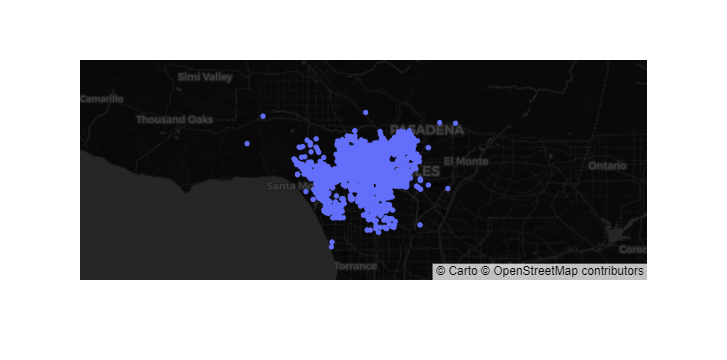

In [25]:
#simple plot on plotly
fig = px.scatter_mapbox(df_fin,
                        lat='lat',
                        lon='lon',
                        mapbox_style="stamen-terrain")
fig.update_layout(mapbox_style="carto-darkmatter")
fig.show()

In [27]:
df_fin.head()


zip_code         city            business_name        location_end_date  \
0  90011-2334  LOS ANGELES           DILCIA L ELIAS  2020-03-19T00:00:00.000   
1  90015-2510  LOS ANGELES  GUILLERMO ESTRADA PRADO  2020-03-19T00:00:00.000   
2  90032-1806  LOS ANGELES     RICHARD J ANDRADE SR  2020-03-19T00:00:00.000   
3  90006-5409  LOS ANGELES      PACKWOOD TRAILS INC  2020-03-19T00:00:00.000   
4  90015-2508  LOS ANGELES             YAFA BARLAVI  2020-03-19T00:00:00.000   

       location_start_date primary_naics_description mailing_address  \
0  2019-12-17T00:00:00.000                       NaN             NaN   
1  2019-06-20T00:00:00.000                       NaN             NaN   
2  2000-01-01T00:00:00.000                       NaN             NaN   
3  2019-03-19T00:00:00.000                       NaN             NaN   
4  2013-08-01T00:00:00.000                       NaN             NaN   

                                             Address        lat         lon  
0  307  E JEFFERSON BLVD, LOS ANGELES, CA, 90011-...  34.017176 -118.269175  
1      326  E PICO BLVD, LOS ANGELES, CA, 90015-2510  34.034886 -118.257986  
2  4348  W ROSE HILL DRIVE, LOS ANGELES, CA, 9003...  34.081726 -118.195891  
3  1408   1/2 S BURLINGTON AVENUE, LOS ANGELES, C...  34.043684 -118.280011  
4      214  E PICO BLVD, LOS ANGELES, CA, 90015-2508  34.035457 -118.259017

In [30]:

#export to csv
df_fin.to_csv('data/closed_businesses.csv', encoding='utf-8')


In [21]:
#there are 6 addresses without Lat, Lon and will not be mapped
df_map.isna().sum()

city                          0
business_name                 0
location_end_date             0
location_start_date           0
primary_naics_description    17
Address                       0
lat                           0
lon                           0
dtype: int64

In [22]:
#delete locations with null lat and lon. you can choose lat or lon in this case
df_map=df_map[df_map['lat'].notna()]
df_map

city                           business_name  \
151          ENCINO                          KEN DUBNER CHT   
2776        ARTESIA                         DIPENDRA KHATRI   
597         TARZANA                    TARZANA LAUNDRY, LLC   
1179    LOS ANGELES                      NEHEMIAS HERNANDEZ   
2778    LOS ANGELES                          MALILEN HOEUNG   
2061    LOS ANGELES                     WORLD POP WEAR, INC   
1682     WILMINGTON               DAVID G. ECHT, ARCHITECTS   
2190    LOS ANGELES                           HWA SOON CHOI   
2162    LOS ANGELES  RICHARD J CHYLINSKI, ARCHITECTURE, INC   
1943  BEVERLY HILLS                            SHANNON WONG   
1568    LOS ANGELES         MARLEIYA ONSHEL MONTERRA BARNES   
223     LOS ANGELES                SAMARITANA DENTAL CLINIC   
723          VERNON                          REVEAUTO, INC.   
2199    LOS ANGELES             DIAL EDUCATION CENTER, INC.   
1217    LOS ANGELES                            AVIS HARRELL   
1583    LOS ANGELES                  BEATRIZ E BREMER PEREZ   
1591        FONTANA                    MARLON PAOLO ESTELLA   
2475    LOS ANGELES                     INTERLUDE HOME, INC   
1092    LOS ANGELES                    FITNESS HEALTH QUEST   
1748    LOS ANGELES                          GROWTHAPPROACH   

            location_end_date      location_start_date  \
151   2020-03-17T00:00:00.000  2007-01-01T00:00:00.000   
2776  2020-09-28T00:00:00.000  2019-06-10T00:00:00.000   
597   2020-04-08T00:00:00.000  2015-10-23T00:00:00.000   
1179  2020-06-01T00:00:00.000  2013-09-10T00:00:00.000   
2778  2020-09-28T00:00:00.000  2017-06-29T00:00:00.000   
2061  2020-07-31T00:00:00.000  2005-08-22T00:00:00.000   
1682  2020-07-01T00:00:00.000  2018-10-01T00:00:00.000   
2190  2020-08-05T00:00:00.000  2019-07-02T00:00:00.000   
2162  2020-08-01T00:00:00.000  1991-02-06T00:00:00.000   
1943  2020-07-20T00:00:00.000  2013-08-28T00:00:00.000   
1568  2020-06-30T00:00:00.000  2019-06-30T00:00:00.000   
223   2020-03-20T00:00:00.000  2019-08-01T00:00:00.000   
723   2020-04-28T00:00:00.000  2016-09-01T00:00:00.000   
2199  2020-08-06T00:00:00.000  1999-03-01T00:00:00.000   
1217  2020-06-01T00:00:00.000  2000-01-01T00:00:00.000   
1583  2020-06-30T00:00:00.000  2013-03-15T00:00:00.000   
1591  2020-06-30T00:00:00.000  2013-02-20T00:00:00.000   
2475  2020-08-31T00:00:00.000  2017-08-01T00:00:00.000   
1092  2020-05-31T00:00:00.000  2005-01-01T00:00:00.000   
1748  2020-07-01T00:00:00.000  2018-06-14T00:00:00.000   

                              primary_naics_description  \
151                                                 NaN   
2776                                                NaN   
597                                                 NaN   
1179                                                NaN   
2778                                                NaN   
2061                                                NaN   
1682                                                NaN   
2190  Drycleaning & laundry services (except coin-op...   
2162                                                NaN   
1943                                                NaN   
1568                                      Beauty salons   
223                                                 NaN   
723                                                 NaN   
2199                                                NaN   
1217                                                NaN   
1583       Cosmetics, beauty supplies, & perfume stores   
1591                                                NaN   
2475                                                NaN   
1092                                                NaN   
1748                                                NaN   

                                                Address        lat         lon  
151    16542    VENTURA BLVD   , ENCINO, CA, 91436-5060  34.157614 -118.493313  
2776     11634    183RD STREET, ARTESIA, CA, 90701-5586  33.865639 -11

In [23]:
map = KeplerGl(height=600,width=800)
map


User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(height=600)

In [24]:
map.add_data(data=df_map, name='Address')

#not sure why this is not displaying, but Kepler isn't ideal for mapping multiple layers
with open('data/ct2010.geojson', 'r') as f:
    geojson = f.read()
map.add_data(data=geojson,name="geojson")

In [25]:
#load geojson and keep necessary columns
svi = gpd.read_file('data/si.json')
svi=svi[['FIPS','RPL_THEMES','geometry']]
svi.head()


FIPS  RPL_THEMES                                           geometry
0  06037101110      0.7248  POLYGON ((-118.28499 34.25589, -118.28493 34.2...
1  06037101122      0.0839  POLYGON ((-118.27743 34.25991, -118.27730 34.2...
2  06037101210      0.8648  POLYGON ((-118.28594 34.25590, -118.29946 34.2...
3  06037101220      0.6927  POLYGON ((-118.28499 34.25589, -118.28594 34.2...
4  06037101300      0.3574  POLYGON ((-118.26528 34.25238, -118.26525 34.2...

In [26]:
#load csv to join data
svi_data = pd.read_csv('data/svi_final.csv')
svi_data=svi_data[['FIPS', 'RPL_THEMES']]

svi_data.info()
svi_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1156 entries, 0 to 1155
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   FIPS        1156 non-null   int64  
 1   RPL_THEMES  1156 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 18.2 KB


FIPS  RPL_THEMES
0  6037194300      0.0008
1  6037137504      0.0026
2  6037141700      0.0034
3  6037262601      0.0035
4  6037261101      0.0060

In [27]:
#convert fips to string 
svi_data['FIPS'] = svi_data['FIPS'].apply(str)
svi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1156 entries, 0 to 1155
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   FIPS        1156 non-null   object 
 1   RPL_THEMES  1156 non-null   float64
dtypes: float64(1), object(1)
memory usage: 18.2+ KB


In [28]:
#add leading zero to join with json data
svi_data['FIPS'] = svi_data['FIPS'].str.zfill(11)
svi_data.head()

FIPS  RPL_THEMES
0  06037194300      0.0008
1  06037137504      0.0026
2  06037141700      0.0034
3  06037262601      0.0035
4  06037261101      0.0060

In [30]:
#add empty folium map 
m = folium.Map(location=[34.051850, -118.243322], tiles=None)

folium.raster_layers.TileLayer(
    location=[34.051850, -118.243322],
    tiles='https://api.mapbox.com/styles/v1/cgiamarino/ckh3zcblc09pp19n0adewnboh/tiles/256/{z}/{x}/{y}@2x?access_token=pk.eyJ1IjoiY2dpYW1hcmlubyIsImEiOiJjanAyd2hwNWUwYnJ3M3dzMHF4MnJkZ29uIn0.7tLnplw65tLmywvvIPGSKA',
    attr='Mapbox',
    API_key='pk.eyJ1IjoiY2dpYW1hcmlubyIsImEiOiJjanAyd2hwNWUwYnJ3M3dzMHF4MnJkZ29uIn0.7tLnplw65tLmywvvIPGSKA',
    name='Monochrome',
    zoom_start=9  # Limited levels of zoom for free Mapbox tiles.
).add_to(m)


#create choropleth
folium.Choropleth(
    geo_data=svi,
    name='SVI',
    data=svi_data,
    popup=svi_data.RPL_THEMES,
    columns=['FIPS', 'RPL_THEMES'],
    fill_color='PuRd',
    key_on='feature.properties.FIPS',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Social Vulnerability Index (SVI)'
).add_to(m)

#create feature group so that business layer can be added to drop down
f2=folium.FeatureGroup(name='Business Closures').add_to(m)

# add the businesses to the feature group
for index, row in df_map.iterrows():
    folium.Circle(
        radius=30,
        location=[row.lat,row.lon], 
        popup=row.business_name+ ' '+row.Address, 
        tooltip=row.business_name,
        overlay=False).add_to(f2)


folium.LayerControl(position='topright', collapsed=True, autoZIndex=True).add_to(m)

m.save('svi_business.html')

m.save('svi.png')

m

In [32]:
import pyscreenshot as ImageGrab

ModuleNotFoundError: No module named 'pyscreenshot'

In [33]:
import selenium.webdriver

ModuleNotFoundError: No module named 'selenium'